In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, precision_score, recall_score, f1_score, PrecisionRecallDisplay
)

In [3]:
# Upload and load the dataset
try:
    from google.colab import files
    uploaded = files.upload()
except Exception as e:
    print(e)
finally:
    data = pd.read_csv("survey.csv")

No module named 'google.colab'


In [4]:
# Print the shape of the data
print("Data shape", data.shape)

Data shape (1259, 27)


In [5]:
# Display the first few rows of the data
data.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [6]:
# Display data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [7]:
# Check for missing values
data.isnull().sum()

Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64

In [8]:
# Display descriptive statistics of the data
data.describe(include='all')

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
count,1259,1.259000e+03,1259,1259,744,1241,1259,1259,995,1259,...,1259,1259,1259,1259,1259,1259,1259,1259,1259,164
unique,1246,NaN,49,48,45,2,2,2,4,6,...,5,3,3,3,3,3,3,3,2,160
top,2014-08-27 12:44:51,NaN,Male,United States,CA,No,No,Yes,Sometimes,6-25,...,Don't know,No,No,Some of them,Yes,No,Maybe,Don't know,No,* Small family business - YMMV.
freq,2,NaN,615,751,138,1095,767,637,465,290,...,563,490,925,774,516,1008,557,576,1075,5
mean,NaN,7.942815e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,2.818299e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,-1.726000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2.700000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,3.100000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,3.600000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Drop unnecessary columns
for col in ['comments', 'state', 'Timestamp']:
    if col in data.columns:
        data.drop(columns=[col], inplace=True)

In [10]:
# Filter data based on Age
if 'Age' in data.columns:
    data = data[(data['Age'] >= 15) & (data['Age'] <= 80)].copy()

In [11]:
# Define function to clean Gender column
def clean_gender(g):
    g = str(g).strip().lower()
    if g in ['male', 'm', 'man', 'cis male', 'male-ish', 'msle', 'malr', 'maile', 'mal']:
        return 'Male'
    elif g in ['female', 'f', 'woman', 'cis female', 'female (cis)', 'femake', 'femail']:
        return 'Female'
    else:
        return 'Other'

In [12]:
# Apply gender cleaning function
if 'Gender' in data.columns:
    data['Gender'] = data['Gender'].apply(clean_gender)

In [13]:
# Group rare countries into 'Other'
if 'Country' in data.columns:
    country_counts = data['Country'].value_counts()
    rare_countries = country_counts[country_counts < 10].index
    data['Country'] = data['Country'].apply(lambda x: 'Other' if x in rare_countries else x)

In [14]:
# Fill missing values in 'self_employed' and 'work_interfere' with mode
if 'self_employed' in data.columns:
    data['self_employed'].fillna(data['self_employed'].mode()[0], inplace=True)
if 'work_interfere' in data.columns:
    data['work_interfere'].fillna(data['work_interfere'].mode()[0], inplace=True)

In [15]:
# Print shape and check for remaining missing values after cleaning
print("\nAfter cleaning, shape:", data.shape)
print("Any NA left:", data.isnull().sum().sum())


After cleaning, shape: (1251, 24)
Any NA left: 0


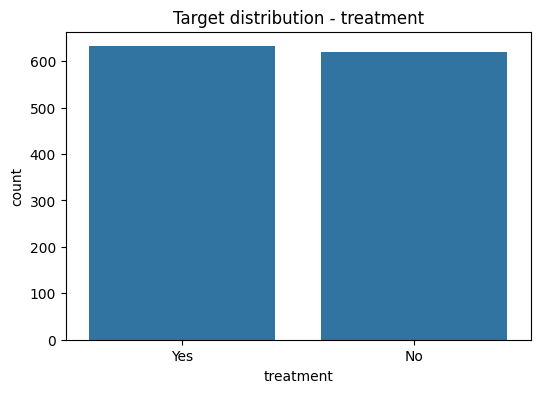

In [16]:
# Plot distribution of the target variable 'treatment'
plt.figure(figsize=(6,4))
sns.countplot(x=data["treatment"])
plt.title("Target distribution - treatment")
plt.show()

<Figure size 1200x600 with 0 Axes>

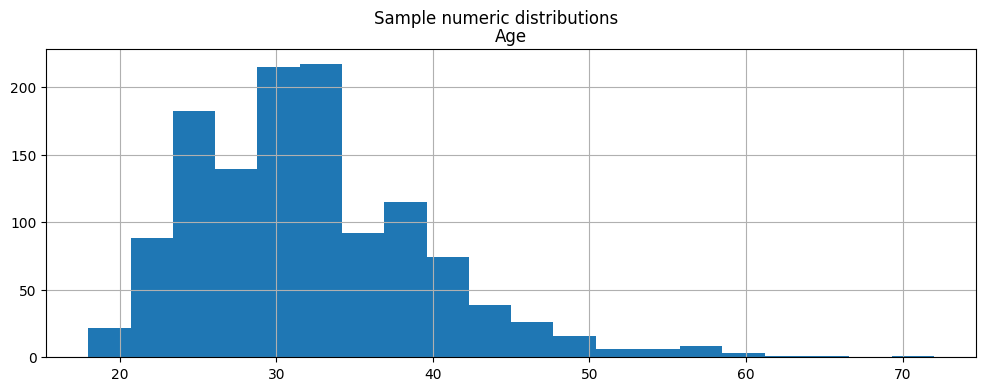

In [17]:
# Plot distributions of numerical columns
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "treatment"]
if len(num_cols):
    plt.figure(figsize=(12, 6))
    data[num_cols].iloc[:, :6].hist(bins=20, layout=(1, min(6, len(num_cols))), figsize=(12,4))
    plt.suptitle("Sample numeric distributions")
    plt.show()

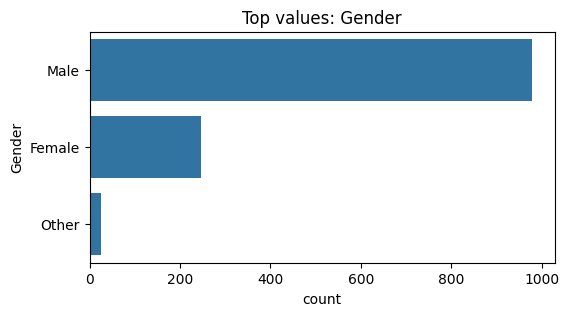

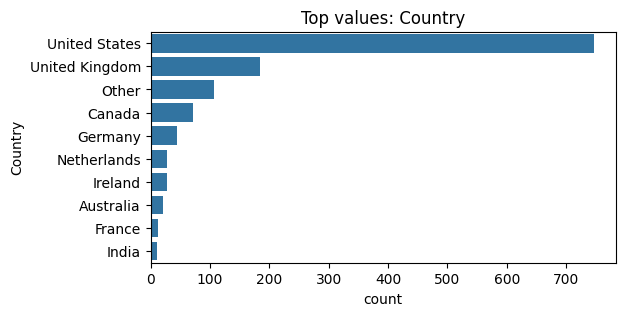

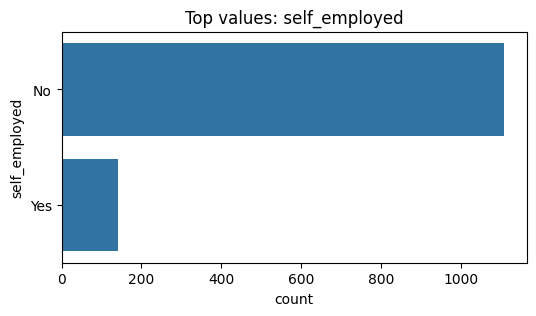

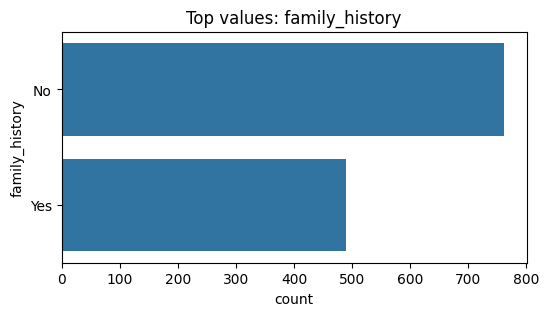

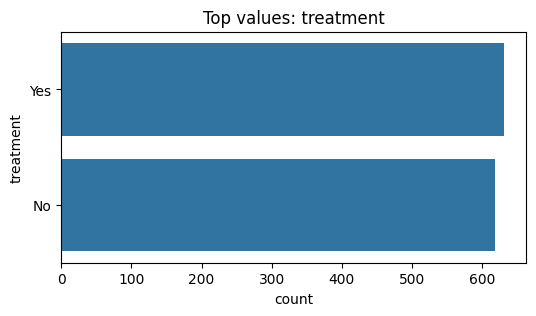

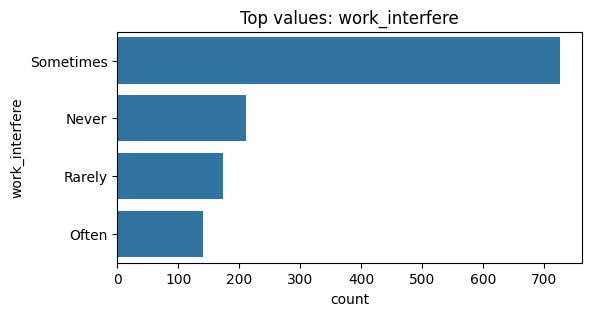

In [18]:
# Plot distributions of categorical columns
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols[:6]:
    plt.figure(figsize=(6,3))
    sns.countplot(y=data[c], order=data[c].value_counts().index[:10])
    plt.title(f"Top values: {c}")
    plt.show()

In [19]:
# Perform one-hot encoding on categorical features
categorical_cols = [
    'Gender', 'Country', 'self_employed', 'remote_work', 'tech_company',
    'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity',
    'leave', 'mental_health_consequence', 'phys_health_consequence',
    'coworkers', 'supervisor', 'mental_health_interview',
    'phys_health_interview', 'mental_vs_physical', 'obs_consequence',
    'work_interfere', 'no_employees', 'family_history'
]

df = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [20]:
# Print the number of features after one-hot encoding
print(f"\nAfter get_dummies, feature count = {len(categorical_cols)}")


After get_dummies, feature count = 22


In [21]:
# Map target variable 'treatment' to numerical values (1 for Yes, 0 for No)
df['treatment'] = df['treatment'].map({'Yes': 1, 'No': 0})

In [22]:
# Separate features (X) and target (y)
X = df.drop('treatment', axis=1)
y = df['treatment']

In [23]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (1000, 53) Test shape: (251, 53)


In [24]:
# Define StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [25]:
# Define machine learning pipelines for different models
pipelines = {
    'Logistic Regression': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=2000, random_state=42))]),
    'Random Forest': Pipeline([('clf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1))]),
    'LightGBM': Pipeline([('clf', LGBMClassifier(n_estimators=300, random_state=42, verbose=-1))])
}

In [26]:
# Define parameter grids for hyperparameter tuning
param_grids = {
    'Logistic Regression': {
        'clf__solver': ['liblinear', 'saga'],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.01, 0.1, 1]
    },

    'Random Forest': {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [5, 10, 15],
        'clf__min_samples_split': [5, 10, 20],
        'clf__min_samples_leaf': [5, 10, 20],
        'clf__max_features': ['sqrt', 'log2']
    },

    'LightGBM': {
        'clf__n_estimators': [100, 200, 500],
        'clf__max_depth': [3, 5],
        'clf__learning_rate': [0.05, 0.01, 0.1],
        'clf__reg_alpha': [0, 0.1, 1],
        'clf__reg_lambda': [0, 0.1, 1]
    }

}

In [27]:
# Initialize lists and variables to store model results
models_summary = []
detailed_results = {}
best_model = None
best_model_name = None
best_rec = -1
best_f1 = -1

In [28]:
# Iterate through models, tune hyperparameters, and evaluate performance
for name, pipeline in pipelines.items():
    print(f"\nTuning and fitting: {name}")

    grid = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=cv,
        scoring='recall',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    best_est = grid.best_estimator_
    y_train_pred = best_est.predict(X_train)
    y_test_pred = best_est.predict(X_test)
    y_train_prob = best_est.predict_proba(X_train)[:, 1]
    y_test_prob = best_est.predict_proba(X_test)[:, 1]

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)

    train_prec = precision_score(y_train, y_train_pred)
    test_prec = precision_score(y_test, y_test_pred)
    train_rec = recall_score(y_train, y_train_pred)
    test_rec = recall_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    if abs(train_rec - test_rec) <= 0.03:
        fit_status = "Good fit"
    elif train_rec > test_rec:
        fit_status = "Overfitting"
    else:
        fit_status = "Underfitting"

    cv_recall = cross_val_score(best_est, X_train, y_train, cv=cv, scoring='recall')
    cv_f1 = cross_val_score(best_est, X_train, y_train, cv=cv, scoring='f1')


    models_summary.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Test Acc': round(test_acc, 3),
        'Test ROC-AUC': round(test_auc, 3) if test_auc else None,
        'Test Precision': round(test_prec, 3),
        'Train Recall': round(train_rec, 3),
        'Test Recall': round(test_rec, 3),
        'Test F1': round(test_f1, 3),
        'CV Mean Recall': round(cv_recall.mean(), 3),
        'CV Mean F1': round(cv_f1.mean(), 3),
        'Fit Status': fit_status
    })

    detailed_results[name] = {
        'estimator': best_est,
        'y_test_pred': y_test_pred,
        'y_test_prob': y_test_prob,
        'report_dict': classification_report(y_test, y_test_pred, output_dict=True),
        'conf_matrix': confusion_matrix(y_test, y_test_pred),
        'test_auc': test_auc
    }

    if (test_rec > best_rec) or (test_rec == best_rec and test_f1 > best_f1):
        best_rec = test_rec
        best_f1 = test_f1
        best_model = best_est
        best_model_name = name


Tuning and fitting: Logistic Regression

Tuning and fitting: Random Forest

Tuning and fitting: LightGBM


In [29]:
# Display model summary and best model
summary_df = (
    pd.DataFrame(models_summary)
    .sort_values(by=['Test Recall', 'CV Mean F1', 'Test ROC-AUC'], ascending=False)
)
print("\n=== Model summary ===")
display(summary_df)

print(f"\nBest model selected: {best_model_name} with Recall = {round(best_rec,3)} and F1 = {round(best_f1,3)}")


=== Model summary ===


,Model,Best Params,Test Acc,Test ROC-AUC,Test Precision,Train Recall,Test Recall,Test F1,CV Mean Recall,CV Mean F1,Fit Status
1,Random Forest,"{'clf__max_depth': 15, 'clf__max_features': 's...",0.741,0.827,0.725,0.800,0.787,0.755,0.768,0.744,Good fit
2,LightGBM,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",0.769,0.860,0.772,0.790,0.772,0.772,0.770,0.765,Good fit
0,Logistic Regression,"{'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__so...",0.777,0.849,0.793,0.762,0.756,0.774,0.741,0.741,Good fit



Best model selected: Random Forest with Recall = 0.787 and F1 = 0.755


<Figure size 800x600 with 0 Axes>

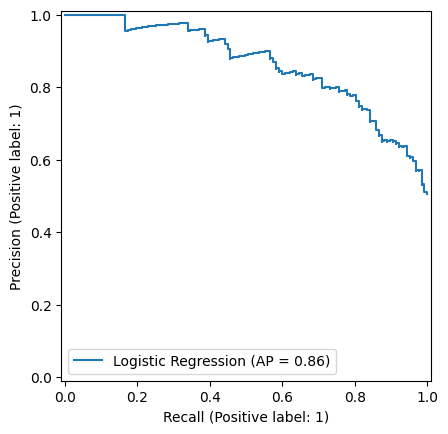

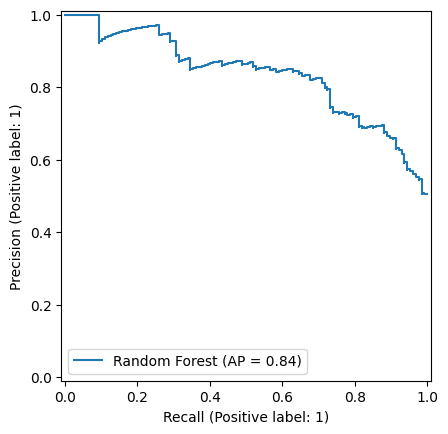

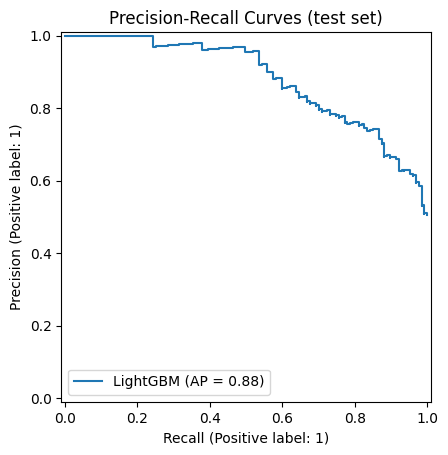

In [30]:
# Plot Precision-Recall curves for all models
plt.figure(figsize=(8,6))
for name, info in detailed_results.items():
    PrecisionRecallDisplay.from_predictions(y_test, info['y_test_prob'], name=name)
plt.title("Precision-Recall Curves (test set)")
plt.show()


--- Logistic Regression ---
Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Test AUC: 0.849
Classification report (test):
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       124
           1       0.79      0.76      0.77       127

    accuracy                           0.78       251
   macro avg       0.78      0.78      0.78       251
weighted avg       0.78      0.78      0.78       251



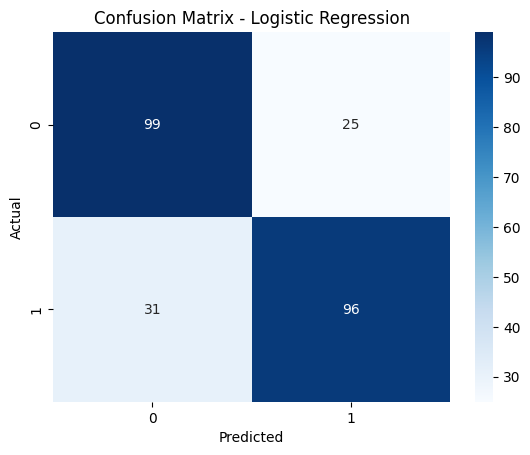


--- Random Forest ---
Best params: {'clf__max_depth': 15, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 20, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}
Test AUC: 0.827
Classification report (test):
              precision    recall  f1-score   support

           0       0.76      0.69      0.73       124
           1       0.72      0.79      0.75       127

    accuracy                           0.74       251
   macro avg       0.74      0.74      0.74       251
weighted avg       0.74      0.74      0.74       251



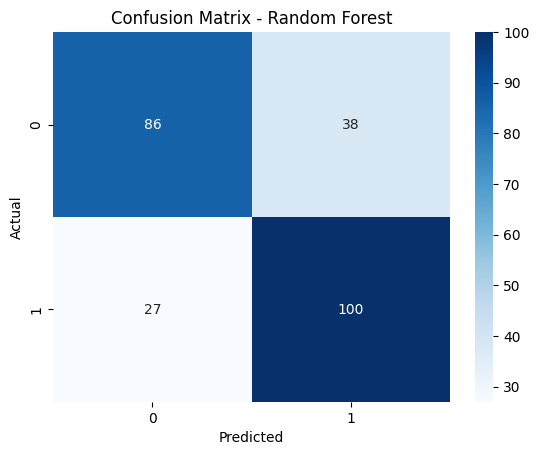


--- LightGBM ---
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__reg_alpha': 0, 'clf__reg_lambda': 1}
Test AUC: 0.86
Classification report (test):
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       124
           1       0.77      0.77      0.77       127

    accuracy                           0.77       251
   macro avg       0.77      0.77      0.77       251
weighted avg       0.77      0.77      0.77       251



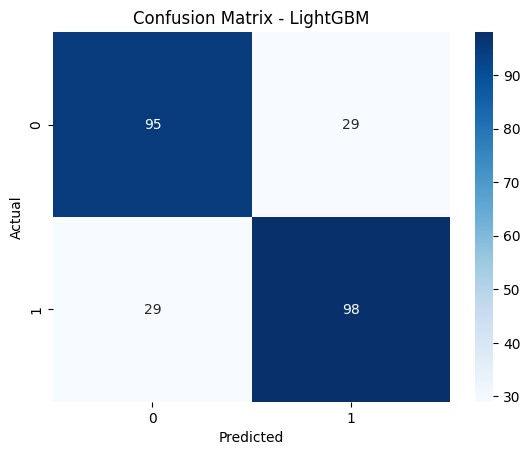

In [31]:
# Print detailed results and confusion matrices for each model
for name, info in detailed_results.items():
    print(f"\n--- {name} ---")
    print("Best params:", summary_df[summary_df['Model']==name]['Best Params'].values[0])
    print("Test AUC:", round(info['test_auc'],3))
    print("Classification report (test):")
    print(classification_report(y_test, info['y_test_pred']))
    sns.heatmap(info['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Interpreting best model: Random Forest


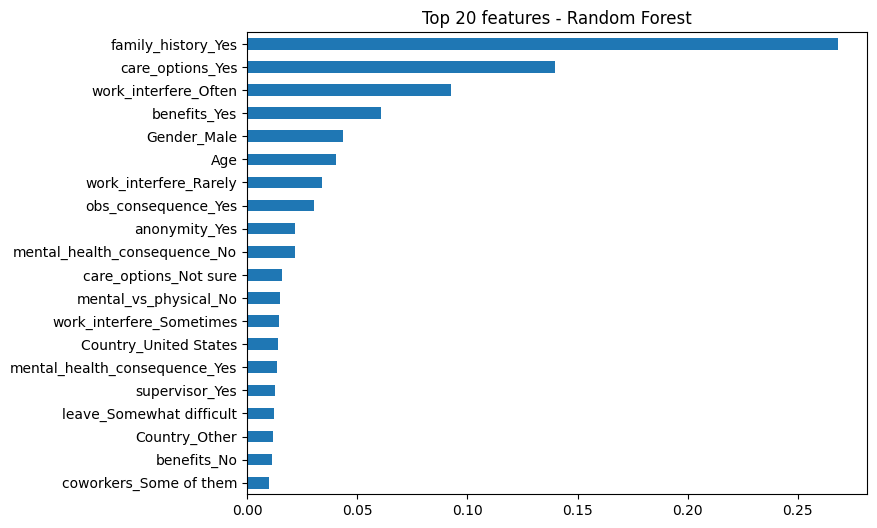

In [32]:
# Interpret the best model (feature importances or coefficients)
print(f"\nInterpreting best model: {best_model_name}")
# Get the actual estimator
estimator = best_model.named_steps.get('clf', best_model) if hasattr(best_model, 'named_steps') else best_model

FEATURE_COLS = X_train.columns

# Feature importances for tree-based models
if hasattr(estimator, "feature_importances_"):
    importances = pd.Series(estimator.feature_importances_, index=FEATURE_COLS).sort_values(ascending=False)
    plt.figure(figsize=(8,6))
    importances.iloc[:20].plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title(f"Top 20 features - {best_model_name}")
    plt.show()


    # Optional SHAP (only if preprocessor exists)
    if hasattr(best_model, 'named_steps') and 'scaler' in best_model.named_steps:
        try:
            preprocessor = best_model.named_steps['scaler']
            X_test_transformed = preprocessor.transform(X_test)
            
            explainer = shap.TreeExplainer(estimator)
            shap_values = explainer.shap_values(X_test_transformed)
            
            shap.summary_plot(shap_values, pd.DataFrame(X_test_transformed, columns=FEATURE_COLS))
            shap.dependence_plot(importances.index[0], shap_values, X_test_transformed)
        except Exception as e:
            print("SHAP explanation failed:", e)

# Coefficients for linear models
elif hasattr(estimator, "coef_"):
    coefs = pd.Series(estimator.coef_.ravel(), index=FEATURE_COLS).sort_values(ascending=False)
    plt.figure(figsize=(8,6))
    coefs.iloc[:20].plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title(f"Top 20 coefficients - {best_model_name}")
    plt.show()


In [33]:
# Store preprocessor metadata
preprocessor_meta = {
    'FEATURE_COLS': FEATURE_COLS,
    'categorical_cols_used': categorical_cols,
    'columns_before_dummies': df.columns.tolist()
}

In [34]:
# Save preprocessor metadata
joblib.dump(preprocessor_meta, "preprocessor_meta.pkl")

['preprocessor_meta.pkl']

In [35]:
# Save the best model and preprocessor metadata
joblib.dump(best_model, "best_model_pipeline.pkl")
print("\nSaved best model pipeline -> best_model_pipeline.pkl")
print("Saved preprocessor metadata -> preprocessor_meta.pkl")


Saved best model pipeline -> best_model_pipeline.pkl
Saved preprocessor metadata -> preprocessor_meta.pkl
